### GBT Raster Scan 1.4-1.5GHz Data Analysis


**First Run:** Clustering Signals in Frequency:

- Histogram of Frequencies as motivation for clustering.
    - _Uniformly distribute frequencies into bins with equiprobability_.
- K-Means Clustering to strengthen the original evidence.
    - _Minimize within cluster variance_
- Clusters weighted by inverse-variance.
    - _More Scattering: Lower Score_
- Feature Extraction of Spectra.
    - _PCA-Whitening with dimensionality reduction factor of 3.33x and information threshold of 92%_
- Anomaly Detection.
    - _Local Outlier Factor to identify basis for spectral clustering_
- Nearest-neighbor subpopulation clustering.
    - _Agglomerative Clustering with average linkage to isolate iso-spectra families_

**Second Run:** Spectral Clusters within Subpopulation

- Feature Extraction of Spectra with Spectral Band as features followed by Whitening the Data Matrix.
- Re-apply Clustering to Isolate similar Spectral Bands with Parent Cluster.
- Apply K-Nearest Neighbors to identify distribution of Iso-Spectral Bands in the Sky.
- Identify Distribution and Likelihood of Signals given their respective Sky Coordinates.

In [179]:
# General Imports.
import os

# Analytics Imports.
import numpy as np
import scipy.linalg as sp
import scipy.optimize as sciopt
import pandas as pd
from sklearn import cluster as skc

#Visualization Imports.
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
DATADIR = './KeplerGBT1.4-1.5GHz'
CATFILE = 'KeplerRasterScan_1.4-1.5Ghz.trimmed.txt'

In [3]:
catalog = pd.read_csv(CATFILE,sep=' ',skipinitialspace=True,usecols=[0,1,2,3],skiprows=1,header=None,names=['path','freq','ra','dec'])

In [4]:
# Get General Statistics.
catalog.describe()

,freq,ra,dec
count,94884.000000,94884.000000,94884.000000
mean,1454.306281,291.819570,44.976942
std,19.191726,5.363247,3.375471
min,1400.000122,279.845500,36.770200
25%,1453.466792,287.114025,42.296575
50%,1459.362224,292.357700,45.284400
75%,1465.927102,296.571600,47.780000
max,1499.999994,301.643200,52.196300


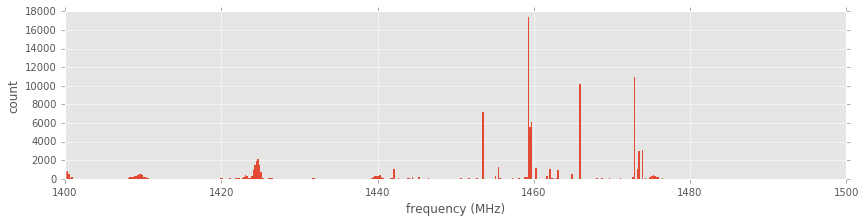

In [5]:
# Use Histogram (Uniform Density Kernel) to Gauge Total Clusters.
plt.figure(figsize=(14,3))

hist = catalog.freq.hist(bins=500,edgecolor='none')
plt.ylabel('count')
plt.xlabel('frequency (MHz)')

plt.show()

In [6]:
# Apply K-Means (Inertia-Minimizing Kernel).
NUM_CLUSTERS = 25
kmeans = skc.KMeans(n_clusters=NUM_CLUSTERS)
data = catalog.freq.reshape(len(catalog.freq),1)
kmeans.fit(data)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=25, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

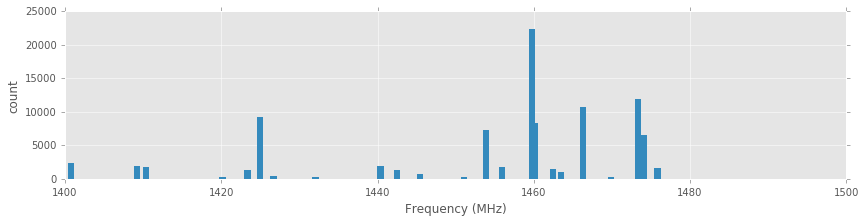

In [7]:
plt.figure(figsize=(14,3))

hist = plt.bar(kmeans.cluster_centers_,np.bincount(kmeans.labels_),edgecolor='none')
# plt.yscale('log')
plt.xlim([1400,1500])
plt.xlabel('Frequency (MHz)')
plt.ylabel('count')

plt.show()

In [8]:
catalog.insert(4,'cluster',kmeans.labels_)

In [9]:
scatter_func = lambda g: 10/(np.var(g['ra'])+np.var(g['dec']))
res = catalog.groupby('cluster').apply(scatter_func)

In [10]:
cluster_stat = pd.DataFrame({'mean_freq': kmeans.cluster_centers_.flatten(),
                             'scatter': res.values})

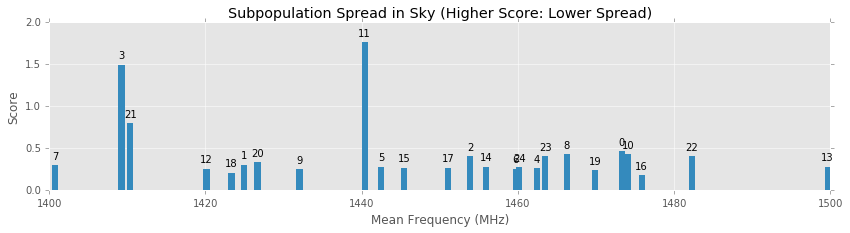

In [23]:
plt.figure(figsize=(14,3))

sbars = plt.bar(cluster_stat.mean_freq.values,cluster_stat.scatter.values,edgecolor='none')
for label, rect in enumerate(sbars):
    plt.gca().text(rect.get_x() + rect.get_width()/2, rect.get_height() + 0.05, label, ha='center', va='bottom')

plt.xlim([1400,1500])
plt.ylim([0,2])
plt.xlabel('Mean Frequency (MHz)')
plt.ylabel('Score')
plt.title('Subpopulation Spread in Sky (Higher Score: Lower Spread)')

plt.show()

In [197]:
def plotSpectra(s,fname):
    # Initialize Figure.
    freqs,s = s[0,:],s[1:,:]
    plt.figure(figsize=(8,5))
    plt.imshow(s, aspect='auto',cmap='Blues')
    cbar = plt.colorbar(pad=.2)
    cbar.set_label('SNR',rotation='270',verticalalignment='bottom')

    # Configure X-Axis.
    band = float(fname.rsplit('_')[-1].rsplit('.',1)[0])
    xpts = np.round((freqs[np.r_[:100:20,-1]]-band)*1000,2)
    plt.gca().set_xticks(np.r_[:100:20,100])
    plt.gca().set_xticklabels(xpts)
    plt.gca().xaxis.grid(False)
    plt.xlabel('Relative Frequency (kHz)')

    # Configure Left Y-Axis.
    yl_pts = np.linspace(-0.15,0.15,6)
    plt.gca().set_yticks(np.r_[:100:20,100])
    plt.gca().set_yticklabels(yl_pts)
    plt.gca().yaxis.grid(False)
    plt.ylabel('Time (s)')

    # Configure Right Y-Axis.
    axr = plt.gca().twinx()
    axr.set_yticks(np.r_[:100:20,100])
    axr.yaxis.tick_right()
    yr_pts = np.linspace(-0.265,0.265,6)
    axr.set_yticklabels(yr_pts)
    axr.yaxis.grid(False)
    axr.set_ylabel('Angular Separation (arcmin)',rotation='270',verticalalignment='bottom')

    plt.title(fname.rsplit('.',1)[0],verticalalignment='bottom')
    plt.show()
    
def plotSpecBand(s):
    # Initialize Figure.
    k = np.argmax(np.var(s[1:,:],0))
    freq,s = s[0,k],s[1:,k]
    plt.figure(figsize=(10,5))
    xpts = np.linspace(-0.265,0.265,100)
    bools = [True] + [False if s[i] < s[i-1] or s[i] < s[i+1] else True for i in range(1,99)] + [True]
    gauss_func = lambda x,a,mu,sigma,b: a * np.exp(-0.5*(((x-mu)/sigma)**2)) + b
    
    # Generate Data & Gaussian Fit.
    cfs,_ = sciopt.curve_fit(gauss_func,xpts[np.nonzero(bools)],s[np.nonzero(bools)],p0=(s.max(),0.02,0.1,0.))
    # cfs,_ = sciopt.curve_fit(gauss_func,xpts,s,p0=(s.max(),0.02,0.1,0.))
    cfs[1] = 0.5*(xpts[s.argmax()] + cfs[1])
    
    # Render Plot.
    plt.plot(xpts,s)
    plt.plot(xpts,gauss_func(xpts,*cfs))
    plt.xlabel('Angular Separation (arcmin)')
    plt.ylabel('Amplitude')
    plt.title('Spectral Band: {0} MHz\n Gaussian Width: {1} arcmin'.format(freq,np.abs(round(cfs[2]*2,3))))
    plt.show()

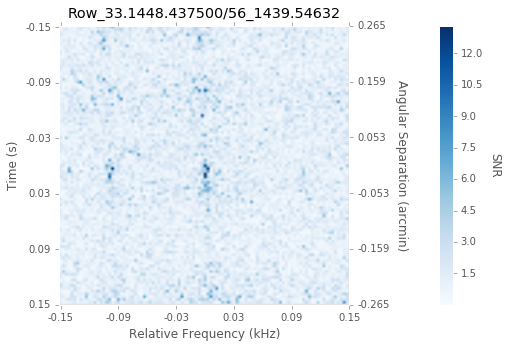

In [156]:
# Examine Spectra of Cluster Member.
N = 11
selCluster = catalog[catalog.cluster == N]
clusterPaths = selCluster.path.values
sample = clusterPaths[np.random.randint(0,clusterPaths.size)]
spectra = np.load(os.path.join(DATADIR,sample))
plotSpectra(spectra,sample)

In [51]:
# PCA-Whitening on Spectogram for Feature Extraction.
def extractSpectraFeatures(s):
    X = s[1:,:]
    D,U = sp.eigh(X.dot(X.T),eigvals=(70,99))
    W = (U.dot(np.diag(D ** (-0.5)))).T
    return W.dot(X).flatten()

# Euclidean Similarity Matrix for kNN.
def nearestNeighbor(M):
    b = M.dot(M.T)
    d = np.diag(b)
    a,c = np.meshgrid(d,d)
    return a - 2*b + c

# Local Outlier Factor (Anomaly Detection).
def localOutlierFactor(k,S):
    D,I = np.sort(S)[:,1:],np.argsort(S)[:,1:]
    reachDist = np.vectorize(lambda a,b: max(D[b,k-1],S[a,b]))
    lrd_func = lambda a: float(k)/np.sum(reachDist(a,I[a,:k]))
    lrd = np.vectorize(lrd_func)
    lof = np.vectorize(lambda a: np.sum(lrd(I[a,:k]))/(k*lrd_func(a)))
    return lof(np.r_[0:S.shape[0]])

In [46]:
dataMatrix = np.empty([clusterPaths.size,3000])
for i,path in enumerate(clusterPaths):
    dataMatrix[i,:] = extractSpectraFeatures(np.load(os.path.join(DATADIR,path)))

In [48]:
S = nearestNeighbor(dataMatrix)

In [69]:
LOF = localOutlierFactor(5,S)

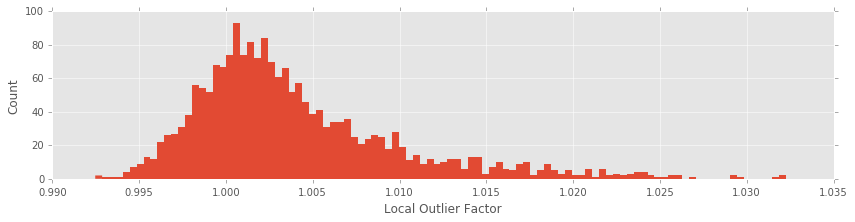

In [72]:
plt.figure(figsize=(14,3))
plt.hist(LOF,bins=100,edgecolor='none')
plt.xlabel('Local Outlier Factor')
plt.ylabel('Count')
plt.show()

In [123]:
agc = skc.AgglomerativeClustering(n_clusters=3,linkage='average')
agc.fit(dataMatrix)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average',
            memory=Memory(cachedir=None), n_clusters=3, n_components=None,
            pooling_func=<function mean at 0x10b5a70c8>)

In [124]:
AGCatalog = pd.DataFrame({'path':clusterPaths,'cluster':agc.labels_})

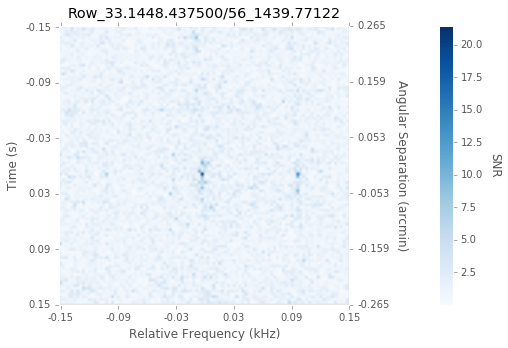

In [178]:
# Examine Agglomerated Cluster
K = 0
cpaths = AGCatalog[AGCatalog.cluster == K].path.values
cpath = cpaths[np.random.randint(0,cpaths.size)]
plotSpectra(np.load(os.path.join(DATADIR,cpath)),cpath)

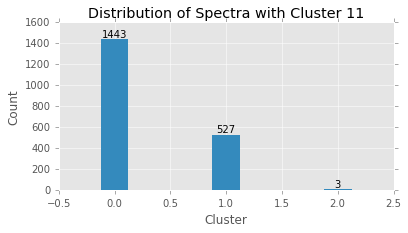

In [153]:
localDist = AGCatalog.groupby('cluster').count()
plt.figure(figsize=(6,3))
dbars = plt.bar(np.r_[0:3],localDist.path.values,edgecolor='none',width=0.25,align='center')
for i, rect in enumerate(dbars):
    plt.gca().text(rect.get_x() + rect.get_width()/2, rect.get_height() + 0.05, localDist.path.values[i], ha='center', va='bottom')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Spectra with Cluster 11')
plt.show()

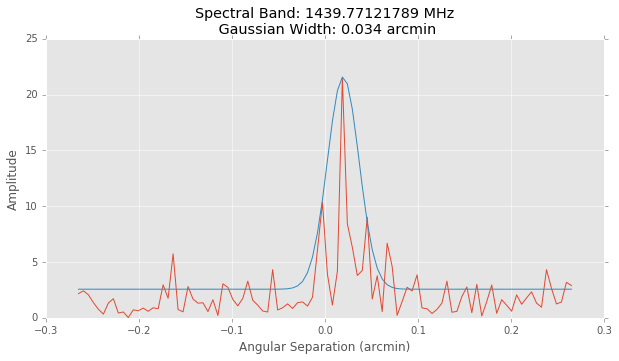

In [198]:
plotSpecBand(np.load(os.path.join(DATADIR,cpath)))

In [199]:
selCluster[selCluster.path == cpath]

,path,freq,ra,dec,cluster
18011,Row_33.1448.437500/56_1439.77122.npy,1439.771218,283.2495,48.6069,11
